In [13]:
import numpy as np
import pandas as pd

import xgboost as xgb
import catboost
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, KFold

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from sklearn.tree import plot_tree
from sklearn.tree import export_text

%matplotlib inline

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/gastonstat/CreditScoring/master/CreditScoring.csv", sep=",")

In [3]:
# Data Cleaning

data.columns = data.columns.str.lower()

status_values = {
    1: "ok",
    2: "default",
    0: "unk"}

data["status"] = data["status"].map(status_values)

home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

data["home"] = data["home"].map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

data["marital"] = data["marital"].map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

data.records = data.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

data.job = data.job.map(job_values)

In [4]:
data.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [5]:
# Extremely large value in columns "income", "assets" and "debt" means that it is missing values
display(data.describe().round())

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [6]:
for col in ["income", "assets", "debt"]:
    data[col].replace(to_replace=99999999.0, value=np.nan, inplace=True)
    print(data[col].max())

959.0
300000.0
30000.0


In [7]:
# Unknown value in "status" is useless and it should be removed
display(data.status.value_counts())

# data[data["status"] == "unk"].index
# data.drop(labels=3309, axis=0, inplace=True)

data = data[data.status != "unk"]

data.reset_index(drop=True)


ok         3200
default    1254
unk           1
Name: status, dtype: int64

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129.0,0.0,0.0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131.0,0.0,0.0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200.0,3000.0,0.0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182.0,2500.0,0.0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107.0,0.0,0.0,310,910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4449,default,1,rent,60,39,married,no,fixed,69,92.0,0.0,0.0,900,1020
4450,ok,22,owner,60,46,married,no,fixed,60,75.0,3000.0,600.0,950,1263
4451,default,0,owner,24,37,married,no,partime,60,90.0,3500.0,0.0,500,963
4452,ok,0,rent,48,23,single,no,freelance,49,140.0,0.0,0.0,550,550


In [8]:
data.status = (data.status == "default").astype("int")

df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=11)
df_train, df_valid = train_test_split(df_full_train, test_size=0.25, random_state=11)

df_test.reset_index(drop=True)
df_train.reset_index(drop=True)
df_valid.reset_index(drop=True)

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,0,6,rent,36,31,separated,no,fixed,49,140.0,0.0,0.0,550,999
1,0,18,rent,60,38,married,no,fixed,56,108.0,0.0,0.0,1000,1307
2,0,17,rent,24,40,married,yes,fixed,58,128.0,0.0,0.0,700,982
3,1,2,other,48,29,married,no,fixed,75,96.0,6000.0,3000.0,1200,1521
4,0,25,rent,42,61,married,no,fixed,57,121.0,0.0,0.0,750,830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,owner,12,21,single,no,fixed,35,147.0,1500.0,0.0,350,350
887,0,12,owner,60,45,married,no,fixed,75,131.0,5000.0,0.0,1150,1452
888,1,2,owner,60,36,married,yes,freelance,60,140.0,29000.0,0.0,3900,4812
889,0,3,parents,24,25,single,yes,fixed,35,128.0,0.0,0.0,300,1397


In [9]:
y_test = df_test.pop("status")
y_train = df_train.pop("status")
y_valid = df_valid.pop("status")

Decision Trees

In [10]:
train_dicts = df_train.fillna(0).to_dict(orient="records")
valid_dicts = df_valid.fillna(0).to_dict(orient="records")
test_dicts = df_test.to_dict(orient="records")

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [11]:
dv.get_feature_names_out();

In [131]:
DT = DecisionTreeClassifier(max_depth=3)
DT.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [12]:
X_valid = dv.transform(valid_dicts)

y_valid_pred = DT.predict_proba(X_valid)[:, 1]

AUC score on valid dataset 0.7389079944782155


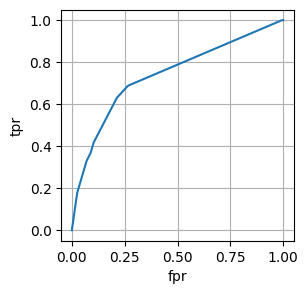

In [133]:
print("AUC score on valid dataset", roc_auc_score(y_valid, y_valid_pred))

fpr, tpr, threshold = roc_curve(y_valid, y_valid_pred)

plt.figure(figsize=(3,3))
plt.plot(fpr, tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.grid()
plt.show()

In [134]:
print("AUC score on train dataset", roc_auc_score(y_train, DT.predict_proba(X_train)[:, 1]))

AUC score on train dataset 0.7761016984958594


[Text(0.5, 0.875, 'records=no <= 0.5\ngini = 0.398\nsamples = 2672\nvalue = [1940, 732]'),
 Text(0.25, 0.625, 'seniority <= 6.5\ngini = 0.491\nsamples = 466\nvalue = [202, 264]'),
 Text(0.125, 0.375, 'amount <= 862.5\ngini = 0.418\nsamples = 269\nvalue = [80, 189]'),
 Text(0.0625, 0.125, 'gini = 0.499\nsamples = 62\nvalue = [32, 30]'),
 Text(0.1875, 0.125, 'gini = 0.356\nsamples = 207\nvalue = [48, 159]'),
 Text(0.375, 0.375, 'income <= 103.5\ngini = 0.472\nsamples = 197\nvalue = [122, 75]'),
 Text(0.3125, 0.125, 'gini = 0.479\nsamples = 68\nvalue = [27, 41]'),
 Text(0.4375, 0.125, 'gini = 0.388\nsamples = 129\nvalue = [95, 34]'),
 Text(0.75, 0.625, 'job=partime <= 0.5\ngini = 0.334\nsamples = 2206\nvalue = [1738, 468]'),
 Text(0.625, 0.375, 'income <= 74.5\ngini = 0.282\nsamples = 1978\nvalue = [1642, 336]'),
 Text(0.5625, 0.125, 'gini = 0.475\nsamples = 387\nvalue = [237, 150]'),
 Text(0.6875, 0.125, 'gini = 0.206\nsamples = 1591\nvalue = [1405, 186]'),
 Text(0.875, 0.375, 'assets <=

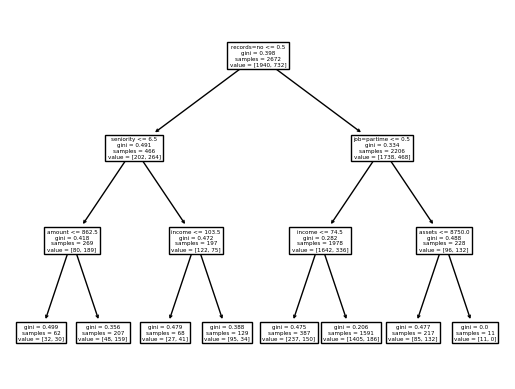

In [140]:

plot_tree(DT, feature_names=dv.get_feature_names_out())

In [147]:
print(export_text(DT,feature_names=dv.feature_names_))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0



Gradient Boosting Trees

In [15]:
dtrain = xgb.DMatrix(
                    data=X_train,
                    label=y_train,
                    feature_names=dv.get_feature_names_out()
                )

dvalid = xgb.DMatrix(
                    data=X_valid,
                    label=y_valid,
                    feature_names=dv.get_feature_names_out()
                )

In [43]:
xgb_params = {
            "eta": 0.3,
            "max_depth": 6,
            "min_child_weight": 1,
            "objective": "binary:logistic",
            "seed": 1,
            "nthread": -1,

}

model = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=200)

In [30]:
model

In [136]:
xgb_params = {
            "eta": 0.3,
            "max_depth": 6,
            "min_child_weight": 1,
            "objective": "binary:logistic",
            "eval_metric":"auc",
            "seed": 1,
            "nthread": -1,
            "verbosity": 1

}

model_2 = xgb.XGBClassifier(**xgb_params)
model_2.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_valid, y_valid)])

[0]	validation_0-auc:0.86300	validation_1-auc:0.76818
[1]	validation_0-auc:0.88485	validation_1-auc:0.79410
[2]	validation_0-auc:0.89923	validation_1-auc:0.80017
[3]	validation_0-auc:0.90951	validation_1-auc:0.80886
[4]	validation_0-auc:0.91967	validation_1-auc:0.80414
[5]	validation_0-auc:0.92863	validation_1-auc:0.80606
[6]	validation_0-auc:0.93385	validation_1-auc:0.80949
[7]	validation_0-auc:0.93880	validation_1-auc:0.81101
[8]	validation_0-auc:0.94150	validation_1-auc:0.81445
[9]	validation_0-auc:0.94581	validation_1-auc:0.81527
[10]	validation_0-auc:0.95002	validation_1-auc:0.81558
[11]	validation_0-auc:0.95342	validation_1-auc:0.81679
[12]	validation_0-auc:0.95555	validation_1-auc:0.81821
[13]	validation_0-auc:0.95985	validation_1-auc:0.81677
[14]	validation_0-auc:0.96176	validation_1-auc:0.81801
[15]	validation_0-auc:0.96558	validation_1-auc:0.81680
[16]	validation_0-auc:0.96741	validation_1-auc:0.81807
[17]	validation_0-auc:0.96981	validation_1-auc:0.81808
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.3,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto',
              random_state=1, ...)

In [62]:
y_valid_pred = model_2.predict_proba(X_valid)[:,1]
roc_auc_score(y_valid, y_valid_pred)
# y_valid_pred

0.8054570003148387

In [63]:
roc_auc_score(y_valid, model.predict(dvalid))


0.8003166549611296

In [78]:
xgb_params = {
            "eta": 0.3,
            "max_depth": 6,
            "min_child_weight": 1,
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "seed": 1,
            "nthread": -1,

}

watchlist = [(dtrain, "train"), (dvalid, "valid")]

model = xgb.train(params=xgb_params, dtrain=dtrain, evals=watchlist, verbose_eval=5, num_boost_round=100)

roc_auc_score(y_valid, model.predict(dvalid))

[0]	train-auc:0.86300	valid-auc:0.76818
[5]	train-auc:0.92863	valid-auc:0.80606
[10]	train-auc:0.95002	valid-auc:0.81558
[15]	train-auc:0.96558	valid-auc:0.81680
[20]	train-auc:0.97316	valid-auc:0.81775
[25]	train-auc:0.98174	valid-auc:0.81878
[30]	train-auc:0.98772	valid-auc:0.81787
[35]	train-auc:0.99180	valid-auc:0.81510
[40]	train-auc:0.99456	valid-auc:0.81387
[45]	train-auc:0.99596	valid-auc:0.81462
[50]	train-auc:0.99688	valid-auc:0.81128
[55]	train-auc:0.99787	valid-auc:0.80874
[60]	train-auc:0.99889	valid-auc:0.80801
[65]	train-auc:0.99919	valid-auc:0.80751
[70]	train-auc:0.99944	valid-auc:0.80732
[75]	train-auc:0.99964	valid-auc:0.80692
[80]	train-auc:0.99985	valid-auc:0.80677
[85]	train-auc:0.99986	valid-auc:0.80671
[90]	train-auc:0.99992	valid-auc:0.80637
[95]	train-auc:0.99996	valid-auc:0.80580
[99]	train-auc:0.99998	valid-auc:0.80546


0.8054570003148387

In [103]:
%%capture output
xgb_params = {
            "eta": 0.3,
            "max_depth": 6,
            "min_child_weight": 1,
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "seed": 1,
            "nthread": -1,

}

watchlist = [(dtrain, "train"), (dvalid, "valid")]

model = xgb.train(params=xgb_params, dtrain=dtrain, evals=watchlist, verbose_eval=5, num_boost_round=100)

roc_auc_score(y_valid, model.predict(dvalid))

with open("log_out.txt", "wt") as f_out:
    f_out.write(output.stdout)

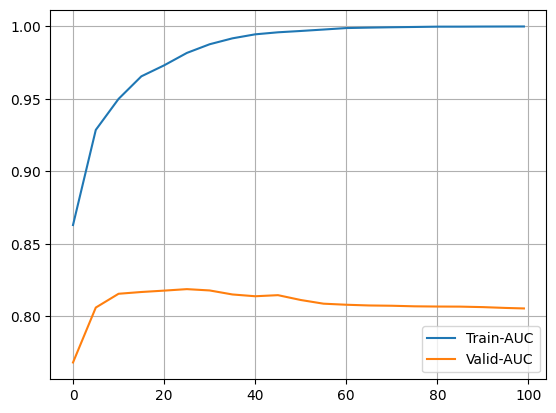

In [128]:
with open("log_out.txt", "rt") as f_in:
    logs = f_in.read()

def parse_xgb_output(logs):

    list_logs=[]

    for s in logs.split("\n")[:-1]:
        dict_logs = {}
        s = s.split("\t")
        
        dict_logs["n_iter"] = int(s[0].strip("[]"))
        dict_logs[s[1].split(":")[0]] = float(s[1].split(":")[1])
        dict_logs[s[2].split(":")[0]] = float(s[2].split(":")[1])
        
        list_logs.append(dict_logs)
        # print(dict_logs)
    
    return pd.DataFrame(list_logs)

df_logs = parse_xgb_output(logs)

plt.plot(df_logs["n_iter"], df_logs["train-auc"], label="Train-AUC")
plt.plot(df_logs["n_iter"], df_logs["valid-auc"], label="Valid-AUC")
plt.legend()
plt.grid()
plt.show()

In [120]:
logs

'[0]\ttrain-auc:0.86300\tvalid-auc:0.76818\n[5]\ttrain-auc:0.92863\tvalid-auc:0.80606\n[10]\ttrain-auc:0.95002\tvalid-auc:0.81558\n[15]\ttrain-auc:0.96558\tvalid-auc:0.81680\n[20]\ttrain-auc:0.97316\tvalid-auc:0.81775\n[25]\ttrain-auc:0.98174\tvalid-auc:0.81878\n[30]\ttrain-auc:0.98772\tvalid-auc:0.81787\n[35]\ttrain-auc:0.99180\tvalid-auc:0.81510\n[40]\ttrain-auc:0.99456\tvalid-auc:0.81387\n[45]\ttrain-auc:0.99596\tvalid-auc:0.81462\n[50]\ttrain-auc:0.99688\tvalid-auc:0.81128\n[55]\ttrain-auc:0.99787\tvalid-auc:0.80874\n[60]\ttrain-auc:0.99889\tvalid-auc:0.80801\n[65]\ttrain-auc:0.99919\tvalid-auc:0.80751\n[70]\ttrain-auc:0.99944\tvalid-auc:0.80732\n[75]\ttrain-auc:0.99964\tvalid-auc:0.80692\n[80]\ttrain-auc:0.99985\tvalid-auc:0.80677\n[85]\ttrain-auc:0.99986\tvalid-auc:0.80671\n[90]\ttrain-auc:0.99992\tvalid-auc:0.80637\n[95]\ttrain-auc:0.99996\tvalid-auc:0.80580\n[99]\ttrain-auc:0.99998\tvalid-auc:0.80546\n'

TypeError: Index(...) must be called with a collection of some kind, 0 was passed